# Discriminant Analysis Notebook

In this notetbook we ilustrate how to use the discriminant anlysis techniques to perform classification. These techniques are implemented in the scikit-learn package. We will compare the properties of LDA and QDA on a simple dataset. We will also show on a dataset with a high number of attributes the performance of the Nearest Shrunken Centroids classifier.

First we load the required packages.

In [36]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import colors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
import pandas as pd

## Loading the Data

We load the data from a CSV file using pandas. The dataset considered is 'Wisconsin Diagnostic Breast Cancer' from the UCI repository. We ignore the first attribute in this dataset, which corresponds to the ID of each sample. The task of interest is to predict whether or not a cell corresponds to a malignant tumor. In this dataset all attributes take real values. These include area, smoothness, perimeter, etc. 

In [37]:
data = pd.read_csv('wdbc.csv')
X = data.values[ :, 2:].astype(float)
y = (data.values[ :, 1 ] == 'B').astype(int)

### Data Partition into Train and Test

We randomly split the data into train and test partitions. We use 70% of the data for training and 30% for testing. 


In [38]:
X_train, X_test, y_train, y_test = train_test_split( \
    X, y, test_size=0.3, random_state=1)

### Data Standardization

We standardize the data to have zero mean and unit standard deviation.

In [39]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

We check the standardization process.

In [40]:
print(np.var(X_train[:,0]))
print(np.var(X_train[:,1]))
print(np.var(X_train_scaled[:,0]))
print(np.var(X_train_scaled[:,1]))

12.278987535686415
18.99872174558559
0.9999999999999997
0.9999999999999999


### Evaluating the Performance of LDA on the Test Set

We train the classifier.

In [41]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

LinearDiscriminantAnalysis()

We compute the confusion matrix on the test set.

In [42]:
y_pred = lda.predict(X_test_scaled)

conf = confusion_matrix(y_test, y_pred)

# The matrix conf contains:
# TN | FN
# FP | TP

TN = conf[0][0]
TP = conf[1][1]
FP = conf[0][1]
FN = conf[1][0]

print(conf)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[ 50   4]
 [  0 117]]
Predicion accuracy is: 0.976608
True postive rate is: 1.000000
True negative rate is: 0.925926



### Evaluating the Performance of QDA on the Test Set

Before training the classifier we will have to choose a good value for the corresponding regularization hyper-parameter. This will be done using a grid-search guided by cross-validation. The regularization parameter regularizes the covariance matrix estimate as $$(1-\lambda)\cdot \mathbf{\Sigma} + \lambda \cdot \mathbf{I}$$.


#### Defining the Pipeline of Data Transformation and Estimation

We create a Pipeline for training the classifier in the inner cross validation procedure. If required, in this pipeline we may also consider extra data transformations such as additional standardization steps for each partition of the data. We omit this step here, since we have already standardized the training data.

In [43]:
pipeline = Pipeline([ ('qda', QuadraticDiscriminantAnalysis()) ])

#### Indicating Potential Values for the Hyperparameters

We specify values for the hyperparameters of the classifier. In this case, the values of lambda. We consider 10 values in the interval $[0,1]$.

In [44]:
reg_param_values = np.linspace(0, 1, 10).tolist()
param_grid = { 'qda__reg_param': reg_param_values }

#### Evaluating the Performance for each Value of the Hyperparameters

We use stratified 10 fold cross-validation, to estimate the performance of the classifier. We use prediction accuracy as the evaluation metric. Other metrics can be considered as well. We will consider 10 splits of the data, corresponding to 10-fold-cv.

In [45]:
skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)
gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
    scoring=make_scorer(accuracy_score))
result = gridcv.fit(X_train_scaled, y_train)

#### Obtaining the Results


We get the mean accuracy and the corresponding standard deviation across data splits.

In [46]:
accuracies = gridcv.cv_results_['mean_test_score']
std_accuracies = gridcv.cv_results_['std_test_score']

We also obtain the accuracy on the test set for comparison purposes.

In [47]:
test_accuracies = np.ones(len(reg_param_values))

for i in range(len(reg_param_values)):
    qda = QuadraticDiscriminantAnalysis(reg_param = reg_param_values[ i ])
    qda.fit(X_train_scaled, y_train)
    test_accuracies[ i ] = accuracy_score(qda.predict(X_test_scaled), y_test)

#### Plotting the Results


For a better visualization of the average results, we plot them, showing also the corresponding standard deviation estimate.

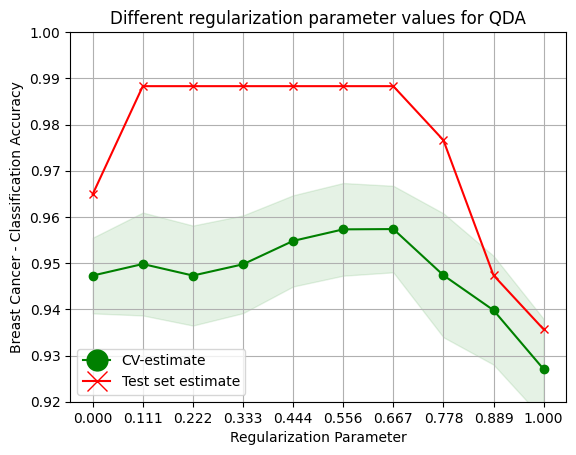

In [48]:
plt.figure()
line1, = plt.plot(reg_param_values, accuracies, 'o-', color="g")
line2, = plt.plot(reg_param_values, test_accuracies, 'x-', color="r")
plt.fill_between(reg_param_values, accuracies - std_accuracies / np.sqrt(10), \
    accuracies + std_accuracies / np.sqrt(10), alpha=0.1, color="g")
plt.grid()
plt.title("Different regularization parameter values for QDA")
plt.xlabel('Regularization Parameter')
plt.xticks(np.array(reg_param_values))
plt.ylabel('Breast Cancer - Classification Accuracy')
plt.ylim((0.92, 1.0))
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                          markersize=15, label='CV-estimate'), \
                mlines.Line2D([], [], color='r', marker='x', \
                          markersize=15, label='Test set estimate')]
plt.legend(handles=legend_handles, loc = 3)
plt.show()

We can observe that the best prediction accuracy is obtained for $\lambda = 2 / 3$, according to the CV-estimate. The CV-estimate is slightly below the test set estimate due to the smaller training set size (90% of training data only is used for training). We cannot make decisions based on the test estimate. Otherwise we will be biasing our restuls.

In [49]:
best_reg_param_value = 2.0 / 3.0

#### Fitting the Final Model and Estimating Its Performance


For this step, we use the whole training data available and the best observed parameter value. 

In [50]:
qda = QuadraticDiscriminantAnalysis(reg_param = best_reg_param_value)
qda.fit(X_train_scaled, y_train)
y_pred = qda.predict(X_test_scaled)
conf = confusion_matrix(y_test, y_pred)

In [51]:
# The matrix conf contains:
# TN | FN
# FP | TP

TN = conf[0][0]
TP = conf[1][1]
FP = conf[0][1]
FN = conf[1][0]

print(conf)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[ 52   2]
 [  0 117]]
Predicion accuracy is: 0.988304
True postive rate is: 1.000000
True negative rate is: 0.962963



## Classification Frontier Visualization


We show how the decision boundaries of the classifier look like for different values of the hyper-parameters. For simplicity, we only consider the first two attributes of the previous problem. We use all the available data.

In [52]:
X = X[:, [0, 1]]

As previously, the first step is to standardize the data. 

In [53]:
X_scaled = preprocessing.scale(X)

We check that the standardization process has been successful.

In [54]:
print(np.var(X[:,0]))
print(np.var(X[:,1]))
print(np.var(X_scaled[:,0]))
print(np.var(X_scaled[:,1]))

12.39260536964082
18.358905874020532
1.0
0.9999999999999998


We plot the data we are going to train the classifier on.

In [55]:
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5

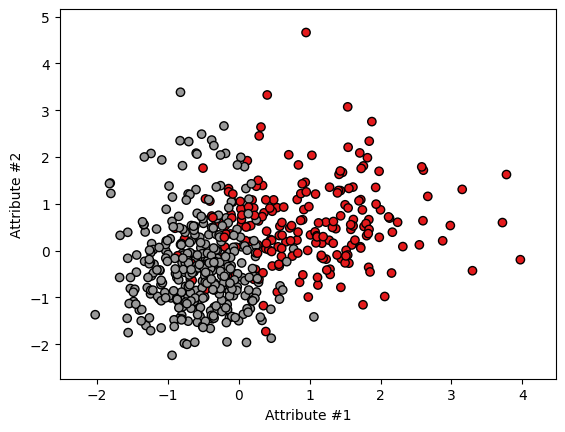

In [56]:
plt.figure()
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.Set1, \
    edgecolor='k')
plt.xlabel('Attribute #1')
plt.ylabel('Attribute #2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

We train the classifiers for and look at the results. For QDA we do not use any regularization at all. We store the covariance matrices found by each method in order to plot the Gaussians fitted.

In [57]:
lda =  LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_scaled, y)

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_scaled, y)

QuadraticDiscriminantAnalysis(store_covariance=True)

We define a function for plotting the elipses of each Gaussian from the eigendecomposition of the covariance matrix.

In [58]:
def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5, \
                              angle = 180 + angle, facecolor=color, \
                              edgecolor='black', \
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


We plot the resulting decision boundaries. And the correspnding estimated Gaussian densities.

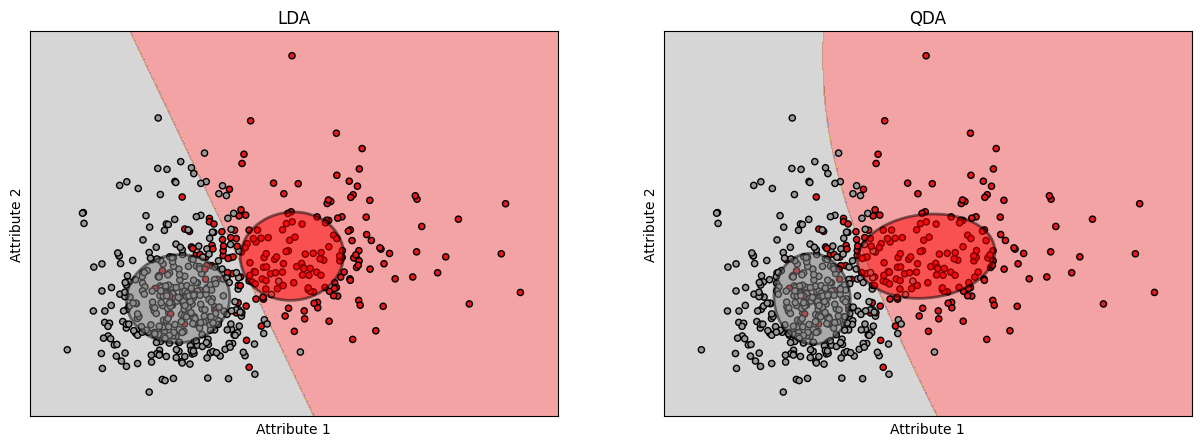

In [59]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 5))

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=20, edgecolor='k',\
    cmap=plt.cm.Set1)
axarr[0].set_title('LDA')
axarr[0].set_xlabel('Attribute 1')
axarr[0].set_ylabel('Attribute 2')

plot_ellipse(axarr[0], lda.means_[0], lda.covariance_, 'red')
plot_ellipse(axarr[0], lda.means_[1], lda.covariance_, 'gray')

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=20, edgecolor='k',\
    cmap=plt.cm.Set1)
axarr[1].set_title('QDA')
axarr[1].set_xlabel('Attribute 1')
axarr[1].set_ylabel('Attribute 2')

plot_ellipse(axarr[1], qda.means_[0], qda.covariance_[0], 'red')
plot_ellipse(axarr[1], qda.means_[1], qda.covariance_[1], 'gray')

plt.show()

We can see that the decision boundaries of LDA are linear while the decision boundaries of QDA are quadratic. The decision boundary is closer to the red class because there are more samples of the gray class. We can see that the covariance matrices of the LDA method are the same, while in QDA they are different. Therefore the estimated class priors are very different. 

In [60]:
print(np.sum(y == 1))
print(np.sum(y == 0))

357
211
